https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

# Flatiron Phase 5 Project

## Aaron Galbraith

https://www.linkedin.com/in/aarongalbraith \
https://github.com/aarongalbraith

### Submitted: November 21, 2023

## working contents

- **[functions](#functions)<br>**
- **[rough overview](#rough-overview)<br>**
- **[missing values](#missing-values)<br>**
- **[duplicates](#duplicates)<br>**
- **[brand / generic pairs](#brand-/-generic-pairs)<br>**
- **[further exploration of duplicates (skip for now)](#further-exploration-of-duplicates-(skip-for-now))<br>**
- **[contractions](#contractions)<br>**
- **[dates](#dates)<br>**
- **[ratings](#ratings)<br>**
- **[focusing on birth control](#focusing-on-birth-control)<br>**
- **[save and reload preprocessed set](#save-and-reload-preprocessed-set)<br>**
- **[feature engineering ideas](#feature-engineering-ideas)<br>**
- **[rudimentary word cloud maker](#rudimentary-word-cloud-maker)<br>**
- **[end](#end)<br>**


## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

import html
import contractions

import re

from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

from pathlib import Path

SEED = 1979

do_grids = True

In [2]:
d1 = pd.read_csv('../data/drugsComTrain_raw.tsv', delimiter='\t', encoding='latin-1')
d2 = pd.read_csv('../data/drugsComTest_raw.tsv', delimiter='\t', encoding='latin-1')
df = pd.concat([d1,d2]).reset_index().drop(columns=['Unnamed: 0', 'index'])

# functions

In [3]:
def show_review(index):
    print(df.review.loc[index])
    display(df[df.review == df.loc[index].review][['drugName', 'condition', 'rating', 'date', 'usefulCount']])

# rough overview

In [4]:
df.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
df.shape

(215063, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215063 non-null  object 
 1   condition    213869 non-null  object 
 2   review       215063 non-null  object 
 3   rating       215063 non-null  float64
 4   date         215063 non-null  object 
 5   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ MB


There are some missing condition labels.

In [7]:
df.drugName.value_counts()

drugName
Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: count, Length: 3671, dtype: int64

In [8]:
df.drugName.value_counts().quantile(.90)

120.0

There are 3,671 unique drug names, and 10% of the drug names have more than 120 reviews.

In [9]:
df.condition.value_counts()

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: count, Length: 916, dtype: int64

In [10]:
df.condition.value_counts().quantile(.90)

332.5

There are 916 unique conditionis, and 10% of the conditions have more than 332 reviews.

In [11]:
df.rating.value_counts()

rating
10.0    68005
9.0     36708
1.0     28918
8.0     25046
7.0     12547
5.0     10723
2.0      9265
3.0      8718
6.0      8462
4.0      6671
Name: count, dtype: int64

Most of the conditions lie at the extremes, and more of them appear to be at the positive extreme.

In [12]:
df.groupby('drugName').condition.nunique().value_counts()

condition
1     1869
2      782
3      334
4      195
5      122
6       83
7       52
8       51
9       38
11      20
10      19
12      19
14      18
13      18
15      11
18       8
16       6
17       5
0        4
20       3
23       3
19       3
25       2
22       2
39       1
24       1
31       1
21       1
Name: count, dtype: int64

This means that, for example, 1869 drugs treat 1 condition only, etc.

In [13]:
df.groupby('condition').drugName.nunique().value_counts()

drugName
2      188
1      166
4       78
3       72
5       44
      ... 
127      1
95       1
81       1
56       1
39       1
Name: count, Length: 71, dtype: int64

This means that 188 conditions are treatable by two drugs, etc.

In [14]:
pd.set_option("display.max_rows", None)
print(df.drugName.value_counts())
pd.set_option("display.max_rows", 10)

drugName
Levonorgestrel                                                                                      4930
Etonogestrel                                                                                        4421
Ethinyl estradiol / norethindrone                                                                   3753
Nexplanon                                                                                           2892
Ethinyl estradiol / norgestimate                                                                    2790
Ethinyl estradiol / levonorgestrel                                                                  2503
Phentermine                                                                                         2085
Sertraline                                                                                          1868
Escitalopram                                                                                        1747
Mirena                                        

A casual overview of the drug names indicates that they all seem valid. Some seem to specify drug combinations and/or dosage amounts.

In [15]:
pd.set_option("display.max_rows", None)
print(df.condition.value_counts())
pd.set_option("display.max_rows", 10)

condition
Birth Control                                                          38436
Depression                                                             12164
Pain                                                                    8245
Anxiety                                                                 7812
Acne                                                                    7435
Bipolar Disorde                                                         5604
Insomnia                                                                4904
Weight Loss                                                             4857
Obesity                                                                 4757
ADHD                                                                    4509
Diabetes, Type 2                                                        3362
Emergency Contraception                                                 3290
High Blood Pressure                                               

Oddly, the condition labels often (always?) omit initial 'F' and terminal 'r'. We can isolate instances of the former by searching for conditions that start with a lower case letter.

We will eventually trim our records to a number of conditions that Planned Parenthood specializes in treating, but we will need all the records to help us determine missing condition labels. After we have restored (or discarded) all missing condition labels, we can drop the conditions outside the scope of this review.

## dates

(Do this date analysis *after* we have trimmed to just the records we'll use?)

There's probably a datetime method for this, but the following will produce month // day // year, and then we can figure out the earliest and latest dates.

In [16]:
df['month'] = df.date.apply(lambda x: re.split(r'\W+', x)[0])
df['day'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[1]))
df['year'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[2]))

In [17]:
df.year.min()

2008

In [18]:
df[df.year == 2008].month.value_counts()

month
March        789
April        716
July         673
November     667
August       664
            ... 
June         648
December     609
May          608
September    606
February     142
Name: count, Length: 11, dtype: int64

In [19]:
df[(df.year == 2008) &
   (df.month == 'February')
  ].day.min()

24

In [20]:
df.year.max()

2017

In [21]:
df[df.year == 2017].month.value_counts()

month
January      4242
March        4152
April        3767
February     3706
May          3653
             ... 
July         2949
September    2682
November     2643
October      2480
December      812
Name: count, Length: 12, dtype: int64

In [22]:
df[(df.year == 2017) &
   (df.month == 'November')
  ].day.max()

30

The reviews span from February 24, 2008 to November 30, 2017.

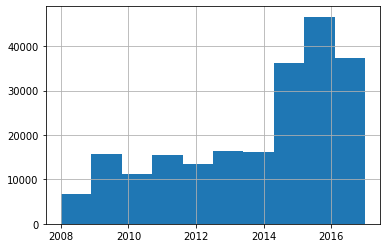

In [23]:
df.year.hist();

## review text

In [24]:
for i in range(10):
    print(df.review[i], '\n-----')

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil" 
-----
"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective." 
-----
"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained horm

# language cleaning

Before we go any further, we would like to clean up some of the review text. In particular, there are many escaped characters, especially apostrophes.

Here is an example of a contraction.

In [25]:
df.review[3][56:69]

'I&#039;m glad'

Here is how the html function fixes it.

In [26]:
html.unescape(df.loc[3][2])[56:64]

"I'm glad"

Here is how the contractions function fixes (the html function's fix of) it.

In [27]:
contractions.fix(html.unescape(df.loc[3][2]))[56:65]

'I am glad'

Here is an instance of "ain't" with the same functions applied.

In [28]:
df.review.loc[507][75:99]

'I ain&#039;t complaining'

In [29]:
html.unescape(df.review.loc[507])[75:94]

"I ain't complaining"

In [30]:
contractions.fix(html.unescape(df.review.loc[507]))[75:96]

'I are not complaining'

In [31]:
len(df[df.review.str.contains('ain&#039;t')])

53

There are 53 instances of "ain't".

I'm currently having difficulty downloading the package that appropriately fixes "ain't" into "is not" or "are not" etc. This shouldn't matter after I remove stop words. I think it will be helpful to exclude negatives like "no" and "not" from the stop words. It could certainly be of help to look for bigrams like "not good".

In [32]:
df.review = df.review.apply(lambda x: html.unescape(x))

# missing values

In [33]:
len(df[df.condition.isna()])

1194

In [34]:
df.condition.fillna('missing', inplace=True)

In [35]:
len(df[df.condition == 'missing'])

1194

We noticed another condition label that was meant to indicate missing and should be accordingly changed.

In [36]:
df.condition = df.condition.apply(lambda x: 'missing' if 'Not Listed' in x else x)

In [37]:
len(df[df.condition == 'missing'])

1786

We've identified some actual missing condition labels, but we noticed there are more condition labels that seem suspicious, particularly ones that start with something other than an upper case character. Let's look at all such condition labels.

In [38]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

{'0</span> users found this comment helpful.',
 '100</span> users found this comment helpful.',
 '105</span> users found this comment helpful.',
 '10</span> users found this comment helpful.',
 '110</span> users found this comment helpful.',
 '11</span> users found this comment helpful.',
 '121</span> users found this comment helpful.',
 '123</span> users found this comment helpful.',
 '12</span> users found this comment helpful.',
 '135</span> users found this comment helpful.',
 '13</span> users found this comment helpful.',
 '142</span> users found this comment helpful.',
 '145</span> users found this comment helpful.',
 '146</span> users found this comment helpful.',
 '14</span> users found this comment helpful.',
 '15</span> users found this comment helpful.',
 '16</span> users found this comment helpful.',
 '17</span> users found this comment helpful.',
 '18</span> users found this comment helpful.',
 '19</span> users found this comment helpful.',
 '1</span> users found this comm

These fall into three categories. Ones that include "users found this comment helpful" should be regarded as erroneous and therefore missing.

In [39]:
df.condition = df.condition.apply(lambda x: 'missing' if 'users found' in x else x)

In [40]:
len(df[df.condition == 'missing'])

2957

Ones that show a clipped copy of the drug name label and end with a parenthesis should also be regarded as missing.

In [41]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x[-1] in ['(', ')'] \
                                  else x)

In [42]:
len(df[df.condition == 'missing'])

3286

# restoring erroneous condition labels

(skip this step because we're just focusing on birth control?)

Most of the ones that show a clipped version of the condition label can possibly be restored.

In [43]:
def condition_restore(condition):
    if condition.split()[-1] in ['Disorde', 'eve', 'Shoulde', 'Cance']:
        condition = condition+'r'
    if condition.split()[0] in ['acial', 'ibrocystic', 'ungal', 'amilial', 'ailure', 'ever', \
                                'emale', 'unctional', 'actor', 'ibromyalgia', 'atigue']:
        condition = 'F'+condition
    if condition.split()[0] in ['llicular', 'llicle', 'lic', 'cal']:
        condition = 'Fo'+condition
    if condition.split()[0] in ['mance']:
        condition = 'Perfor'+condition
    if condition.split()[0] in ['zen']:
        condition = 'Fro'+condition
    if condition.split()[0] in ['mis']:
        condition = 'Dermatitis Herpetifor'+condition
    return condition

df.condition = df.condition.apply(lambda x: condition_restore(x))

Let's look at what we have left.

In [44]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

{'m Pain Disorder', 'me', 't Care', "von Willebrand's Disease"}

"von Willebrand's Disease" appears to be a naturally uncapitalized condition. The others have been impossible to restore and will also be regarded as missing.

In [45]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x.split()[0] != 'von' \
                                  else x)

In [46]:
len(df[df.condition == 'missing'])

3293

We will be able to restore more of these missing condition labels after we do some work with duplicates.

# duplicates

In [47]:
df.duplicated().value_counts()

False    215061
True          2
Name: count, dtype: int64

In [48]:
df[df.duplicated()]

,drugName,condition,review,rating,date,usefulCount,month,day,year
178703,Levonorgestrel,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10,September,23,2016
191001,Plan B,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10,September,23,2016


In [49]:
show_review(178703)

"I had a quickie n he decided to finish it off in me... Well IMMEDIATELY we went 2 our local pharmacy n bought this plan b 1 step pill.I took it immediately.2 weeks later,took a pregnancy test n got the world's BIGGEST POSITIVE. The small pill was $50.That was the 1st time in a year n a half that I had intercourse n the last after I had my first son. I honestly believe this pill is ineffective because they just want u to think it works when n reality, it would never work. Alot of women don't know their bodies when they ovulate so if your not fertile and he ejaculates n u and u take the pill n dont get preg., The pill is supposed to make u think it worked. DO NOT buy. Was NEVER effective. Thank u!"


,drugName,condition,rating,date,usefulCount
131531,Levonorgestrel,Emergency Contraception,1.0,"September 23, 2016",10
143768,Plan B,Emergency Contraception,1.0,"September 23, 2016",10
178703,Levonorgestrel,Emergency Contraception,1.0,"September 23, 2016",10
191001,Plan B,Emergency Contraception,1.0,"September 23, 2016",10


This is curious. The same review is recorded four times. There are two identical pairs, where the difference between the pairs is the drug name. We can drop one from each pair, but the pairs themselves will need to be revisited.

In [50]:
df.drop_duplicates(inplace=True)

# brand / generic pairs

The main type of duplicate we should look out for is records with duplicate reviews, as those likely indicate some kind of actual erroneous duplication. Let's see how many of those there are.

In [51]:
df.duplicated(subset=['review']).value_counts()

False    128478
True      86583
Name: count, dtype: int64

That's a lot!

Let's explore some facets of these duplicates.

In [52]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

85876

The vast majority of duplicate reviews are accounted for by different drug names. Let's explore some examples.

In [53]:
df[df.duplicated(subset=df.columns.difference(['drugName']))].head()

,drugName,condition,review,rating,date,usefulCount,month,day,year
524,Nexplanon,Birth Control,"""First had implanon then got Nexplanon, had a ...",9.0,"April 21, 2017",5,April,21,2017
574,Cymbalta,Anxiety,"""Prescribed via a Psychiatrist for severe Pani...",1.0,"September 5, 2010",27,September,5,2010
726,Orsythia,Birth Control,"""I have only been on orsythia for about 1 mont...",2.0,"October 8, 2015",7,October,8,2015
1070,Desvenlafaxine,Depression,"""I have suffered from severe anxiety (GAD) and...",8.0,"November 1, 2013",81,November,1,2013
1375,Ethinyl estradiol / norethindrone,Birth Control,"""I have been taking my first pack of Lo Loestr...",8.0,"February 1, 2012",7,February,1,2012


In [54]:
show_review(524)

"First had implanon then got Nexplanon, had a period first month and I have not had one since. I'm due to remove it next year.  I do notice spotting  sometimes for a day but it honestly  usually coincides with when I'm stressed. 
Had some weight gain also.

So far the best BC I've  had in all my years.  I plan on trying for a baby next year then I will be back on it."


,drugName,condition,rating,date,usefulCount
374,Etonogestrel,Birth Control,9.0,"April 21, 2017",5
524,Nexplanon,Birth Control,9.0,"April 21, 2017",5


In [55]:
show_review(574)

"Prescribed via a Psychiatrist for severe Panic attacks for 2 years.
If I take dosage late or forget to take it the withdrawal symptoms kick in.  
Gnawing physical pain, breathlessness, disorientation to time, difficulties in word finding while speaking, severe muscle pain and stiffness, nausea, labile emotions and panic.

"


,drugName,condition,rating,date,usefulCount
321,Duloxetine,Anxiety,1.0,"September 5, 2010",27
574,Cymbalta,Anxiety,1.0,"September 5, 2010",27


In [56]:
show_review(726)

"I have only been on orsythia for about 1 month and I just started my second week of my second month.  I guess I didn't notice earlier but I started to get slight headaches and I didn't feel very well physically and mentally.  It do help with my cramps and my period, not so much my acne but it's better.  The worst part of orsythia has to be the mood swings and the sweating!  I sweat a lot even if it's cold I'll start a light sweat, it's gross.  But the mood swings are the worst I just started feeling this and it happened while I was talking to one of my friends I just blew up on him, for no reason.  Then later on I started to feel really bad(mentally) and I cried for a while and I couldn't figure out why I was crying! I don't recommend!"


,drugName,condition,rating,date,usefulCount
378,Ethinyl estradiol / levonorgestrel,Birth Control,2.0,"October 8, 2015",7
726,Orsythia,Birth Control,2.0,"October 8, 2015",7


In [57]:
show_review(1070)

"I have suffered from severe anxiety (GAD) and was taking more and more Klonopin as time went on.  I am very sensitive to medication and have tried many different SSRI/SNRI's through the year with horrible side effects.  Finally, I had DNA testing to see what I would respond to and the result was Pristiq.  I started it several months ago in a small dose (I split the pills even though they say don't do this) and within a few days my anxiety literally went away.  I was able to cut my Klonopin in 1/2 over a two month period.  The first week or two I was extremely tired but that passed.  The only side effect I get from time to time is migraines.  It still amazes me that my anxiety has disappeared.  I no longer keep Klonopin in my  pocket!"


,drugName,condition,rating,date,usefulCount
855,Pristiq,Depression,8.0,"November 1, 2013",81
1070,Desvenlafaxine,Depression,8.0,"November 1, 2013",81


In [58]:
show_review(1375)

"I have been taking my first pack of Lo Loestrin Fe and I must say it really works for me. I was a little nervous at first because this is my first time taking birth control and I've heard all the negative side effects of taking birth control. I have had spotting [brown-ish color] for three weeks after my period, but that's normal for the first month. I have breast tenderness and mood swings every now and then, then again it's expected for the first few months. I have not yet experienced any weight gain. So far I am satisfied, but I wish it wasn't so expensive."


,drugName,condition,rating,date,usefulCount
609,Lo Loestrin Fe,Birth Control,8.0,"February 1, 2012",7
1375,Ethinyl estradiol / norethindrone,Birth Control,8.0,"February 1, 2012",7


These five examples make clear that the vast majority of duplicates are due to double-entry; (nearly) every review is entered once with its generic name and once with its brand name.

We can use this phenomenon to restore some of the missing condition labels. If a missing condition label is part of such a unique pair, then we can confidently assign it the condition of its pair-mate.

Let's broaden our search to records that duplicate every feature other than drug name and condition.

In [59]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))])

86221

This is how many records are duplicates of other records in all values EXCEPT (POSSIBLY) drug name and condition. If a record is duplicated in this manner, the second (and third, fourth, etc.) instance will be captured in this bucket of dupes.

If we check only this bucket for dupes, we can see whether there are any triplets, etc.

In [60]:
df_dupes = df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))]

In [61]:
len(df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))])

1

There is only one.

In [62]:
df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))]

,drugName,condition,review,rating,date,usefulCount,month,day,year
140144,Octreotide,"Diabetes, Type 1","""Great medicine. No side effects.""",9.0,"October 31, 2011",2,October,31,2011


In [63]:
show_review(140144)

"Great medicine. No side effects."


,drugName,condition,rating,date,usefulCount
39512,Reprexain,Pain,7.0,"October 5, 2012",10
60998,Insulin regular,"Diabetes, Type 1",9.0,"October 31, 2011",2
119972,Insulin glulisine,"Diabetes, Type 1",9.0,"October 31, 2011",3
133212,Sandostatin,"Diabetes, Type 1",9.0,"October 31, 2011",2
140144,Octreotide,"Diabetes, Type 1",9.0,"October 31, 2011",2
141100,Insulin isophane / insulin regular,"Diabetes, Type 1",9.0,"October 31, 2011",10
148049,ReliOn / Novolin 70 / 30,"Diabetes, Type 1",9.0,"October 31, 2011",10
184262,Hydrocodone / ibuprofen,Pain,7.0,"October 5, 2012",10


There are 6 records with the same review, date, rating, and condition. (The reviews on October 5, 2012, appear to be just a coincidence of the same review wording.) Because they're on the *same day*, it seems likely that these reviews were possibly entered repeatedly by the same person. The two with a useful count of 10 are likely a brand/generic pair.

As for the other 4, it's not clear what is going on. We will (would) later discover that there is also some discrepancy as to which of these is a brand or generic name. Since the review text isn't very descriptive, and the useful count is so low, (and it doesn't pertain to the main conditions treated by Planned Parenthood), let's just drop all 4.

In [64]:
df.drop([60998, 119972, 133212, 140144], inplace=True)

Now we should be able to create a list of pairs of indices of records that match in all features except possibly drug name and condition. To make this run faster, we'll first create a way to sort them by date.

In [65]:
%%time
# ⏰ record the time for this cell -- usually 11-12 s

# create stripped down dataframe that does not have drug names or conditions
# we don't need these features for this operation because we're checking for matches on all other features
df_pairs = df.drop(columns=['drugName', 'condition']).copy()

# create a list of indices of records that duplicate everything other than drug name and condition
df_dupes = df_pairs[df_pairs.duplicated()].index.tolist().copy()

# create and populate a dictionary whose keys are dates and whose values are indices
dates_dict = {}
# populate dictionary with keys that are dates belonging to the duplicates
for date_ in list(set(df[df.index.isin(df_dupes)].date.tolist())):
    dates_dict[date_] = []
# populate dictionary with values that are indices that are NOT from the duplicate list but DO share that date
for i in df[~df.index.isin(df_dupes)].index:
    dates_dict[df.loc[i].date].append(i)

CPU times: user 8.36 s, sys: 45.1 ms, total: 8.41 s
Wall time: 8.42 s


Now we can use this dates dictionary to sort and identify the pairs.

In [66]:
%%time
# ⏰ record the time for this cell -- usually 2–4 mins

# create a list of record pairs where each entry is a list of two indices
pairs = []

# iterate over the indices from the dupes list
for i in df_dupes:
    # set the date to the date from index i
    date_i = df.loc[i].date
    # iterate over OTHER indices who share that date
    for j in dates_dict[date_i]:
        # check for a match
        if df_pairs.loc[i].equals(df_pairs.loc[j]) and df.drugName.loc[i] != df.drugName.loc[j]:
            # remove this index from the dates dictionary so we have fewer to search through in later iterations
            dates_dict[date_i].remove(j)
            # add this pair to the pairs list
            pairs.append([i,j])
            break

CPU times: user 2min 3s, sys: 145 ms, total: 2min 3s
Wall time: 2min 3s


Let's take a look at several of the pairs we've collected.

In [68]:
pairs[:10]

[[524, 374],
 [574, 321],
 [726, 378],
 [1070, 855],
 [1375, 609],
 [1397, 1281],
 [1735, 1043],
 [1965, 299],
 [2014, 1844],
 [2091, 1609]]

Here we'll create a dictionary that matches the index of one pair member to the other member of the pair.

In [69]:
pairs_dict = {}

for pair in pairs:
    for i in range(2):
        pairs_dict[pair[i]] = pair[1-i]

# restore missing condition labels

We will restore missing condition labels in two ways, in order of certainty:

1. For missing values that possess a pair match, we will assign it the condition of its match.
2. For the remaining missing values, we will assign it the condition that is most commonly associated with its drug name.

In [70]:
len(df[df.condition == 'missing'])

3293

In [71]:
%%time
# ⏰ record the time for this cell -- usually 10-15 seconds

# iterate over each record pair
for pair in pairs:
    # iterate over each member of the pair
    for i in range(2):
        # identify a pair member whose condition is missing
        if df.loc[pair[i]].condition == 'missing':
            # assign to the pair member the condition of its pair-mate
            df.at[pair[i], 'condition'] = df.loc[pairs_dict[pair[i]]].condition

CPU times: user 11.1 s, sys: 25.4 ms, total: 11.1 s
Wall time: 11.1 s


In [72]:
len(df[df.condition == 'missing'])

2968

Because it will be useful later, we'll make a feature that names the indicated drug and, if applicable, the paired drug.

This is not a *final* replacement for the drug name feature, but it will allow us to better recognize the relationship between the generic and brand drug names.

In [73]:
%%time
# ⏰ record the time for this cell -- usually 15-30 seconds

df['ind'] = df.index

def drugList_fix(index, drugName_):
    drugList = [drugName_]
    if index in pairs_dict:
        drugList.append(df.loc[pairs_dict[index]].drugName)
        # alphabetize each drug pair so that we will not mistakenly duplicate e.g. [A,B] & [B,A]
        drugList.sort()
    return drugList

df['drugList'] = df.apply(lambda x: drugList_fix(x.ind, x.drugName), axis=1)

df.drop(columns='ind', inplace=True)

CPU times: user 14.5 s, sys: 69.9 ms, total: 14.6 s
Wall time: 14.6 s


Now we can create a feature that tells us if a record is associated with a paired drug name or not.

In [74]:
df['isPaired'] = df.drugList.apply(lambda x: True if len(x) > 1 else False)

In [75]:
len(df[df.isPaired])

172438

In [76]:
len(df[~df.isPaired])

42619

Because lists confuse certain operations

In [77]:
df['drugSetString'] = df.drugList.apply(lambda x: x[0] + ' ' + x[1] if len(x) == 2 else x[0])

In [78]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']))])

86199

With this new feature in place, we can drop one record from each of the brand/generic pairs. The drug name feature will retain only one member of the pair -- unpredictably either the brand or the generic -- which will make this feature more or less useless for the moment.

Before we drop these records, we'll create a bookmark copy of the dataframe.

In [79]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage,
# in ANOTHER CELL write the code `df = df_bookmark_1.copy()` and immediately delete that code
df_bookmark_1 = df.copy()

In [80]:
df.drop_duplicates(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']), inplace=True)

For every remaining record with a missing condition, we will assign it the condition that is most common for the drug indicated by that record. (This will not be biased by duplicates from brand/generic pairs, because we have dropped those duplicates.)

This will be the last use we have for conditions *not* treated by Planned Parenthood.

In [81]:
drugs_w_missing_condition = list(set(df[df.condition == 'missing'].drugSetString))

In [82]:
len(drugs_w_missing_condition)

678

In [83]:
df.drugSetString.nunique()

3320

This applies to some 20% of the drugs. We'll create a dictionary that reports the most common condition for these drugs.

In [84]:
%%time
# record the time for this cell -- 10-20 seconds

most_common_condition = {}

for drug in drugs_w_missing_condition:
    condition = df[df.drugSetString == drug].condition.value_counts().idxmax()
    if condition == 'missing' and len(set(df[df.drugSetString == drug].condition)) > 1:
        condition = df[(df.drugSetString == drug) &
                       (df.condition != 'missing')
                      ].condition.value_counts().idxmax()
    proportion = round(df[df.drugSetString == drug].condition.value_counts(normalize=True)[0],2)
    most_common_condition[drug] = [condition, proportion]

CPU times: user 9.95 s, sys: 20.4 ms, total: 9.97 s
Wall time: 9.98 s


In [85]:
most_common_condition['Sildenafil Viagra']

['Erectile Dysfunction', 0.87]

For example, if a review with an unlisted condition is about Viagra, we will assume the condition is Erectile 
Dysfunction.

In [86]:
len(df[df.condition == 'missing'])

1799

In [87]:
df['condition'] = df.apply(lambda x: most_common_condition[x.drugSetString][0] \
                           if x.condition == 'missing' \
                           else x.condition, axis = 1)

In [88]:
len(df[df.condition == 'missing'])

27

This is how many records there are that still have no condition label. This means the drugs indicated in these records are *only* indicated in references without an indicated condition. As such, there's not really anything we can do with these records, and we may as well drop them.

In [89]:
df.drop(df[df.condition == 'missing'].index, inplace=True)

In [90]:
len(df[df.condition == 'missing'])

0

# trim by conditions

At this point, we still have more cleaning to do, but we have identified all the conditions that we can, and we won't have any further need for records with certain condition values, so we'll drop them.

In [91]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage,
# in ANOTHER CELL write the code `df = df_bookmark_2.copy()` and immediately delete that code
df_bookmark_2 = df.copy()

Let's take another look at the complete list of conditions and choose which ones to keep.

In [92]:
df.condition.nunique()

817

Since there are so many conditions to consider, let's limit this to just conditions with at least 25 reviews.

In [93]:
pd.set_option("display.max_rows", None)
display(df['condition'].value_counts().loc[lambda x: x >= 25])
pd.set_option("display.max_rows", 10)

condition
Birth Control                                                 20054
Depression                                                     7208
Pain                                                           5295
Anxiety                                                        5189
Acne                                                           4571
Insomnia                                                       3471
Bipolar Disorder                                               3333
Weight Loss                                                    3153
Obesity                                                        2780
Vaginal Yeast Infection                                        2648
ADHD                                                           2453
High Blood Pressure                                            2316
Diabetes, Type 2                                               1864
Emergency Contraception                                        1735
Anxiety and Stress                    

In [94]:
pp_conditions = [
    'Birth Control', 'Emergency Contraception', 'Abnormal Uterine Bleeding', \
    'Menstrual Disorders', 'Female Infertility', 'Uterine Fibroids'
]

In [95]:
df.drop(df[~df.condition.isin(pp_conditions)].index, inplace=True)

In [96]:
df.condition.value_counts()

condition
Birth Control                20054
Emergency Contraception       1735
Abnormal Uterine Bleeding     1464
Menstrual Disorders            260
Female Infertility              51
Uterine Fibroids                36
Name: count, dtype: int64

# exploring generic and brand names

Now that we have a smaller number of records to deal with, we can sort out generic and brand names.

First we'll create a list of all values from the drug name feature. (Some of these have been dropped from the drug name feature itself when we dropped one record from each brand/generic pair, but all of them were included in the drug list feature.)

We'll create two lists: paired drugs (which we will attempt to sort into brand and generic) and single drugs (each of which we will then try to identify as either brand or generic).

In [128]:
len(df)

23600

In [129]:
all_drug_lists = df.drugList.tolist()
all_drug_lists.sort()

In [130]:
len(all_drug_lists)

23600

In [131]:
all_drug_names = set()

for list_ in all_drug_lists:
    all_drug_names.add(list_[0])
    if len(list_) > 1:
        all_drug_names.add(list_[1])

all_drug_names = list(all_drug_names)

all_drug_names.sort()

In [132]:
len(all_drug_names)

208

In [133]:
# this will create a full list with duplicates
# we need to do this intermediate before moving to the following step to remove duplicates
paired_drug_lists = df[df.isPaired].drugList.tolist()
paired_drug_lists.sort()

In [134]:
len(paired_drug_lists)

22567

In [135]:
paired_drug_names = set()

for pair in paired_drug_lists:
    paired_drug_names.add(pair[0])
    paired_drug_names.add(pair[1])

paired_drug_names = list(paired_drug_names)

paired_drug_names.sort()

In [136]:
unpaired_drug_names = [drug for drug in all_drug_names if drug not in paired_drug_names]

unpaired_drug_names.sort()

In [137]:
len(paired_drug_names)

206

In [138]:
len(unpaired_drug_names)

2

Together, these two lists of names constitute all the drug names left to sort into brand and generic categories.

In order to sort the list of paired drugs into brand and generic, we'll establish a dictionary whose keys are all the drug names that appear in a generic/brand pair.

In [139]:
drug_dict = {}

for drug in paired_drug_names:
    drug_dict[drug] = set()

We'll assign values to those keys according to the pairings. For example, if drug name A is in a generic/brand pair with drug name B, then they will appear on each other's list of values in this dictionary.

In [140]:
for pair in paired_drug_lists:
    drug_dict[pair[0]].add(pair[1])
    drug_dict[pair[1]].add(pair[0])

Let's find out how many of these drug names are associated with exactly one other drug name.

In [141]:
len({drug for drug in drug_dict if len(drug_dict[drug]) == 1})

192

That should mean that exactly the remainder are associated with multiple drug names. It would make sense that drug names that belong to multiple generic/brand pairs are themselves the generic name. On that assumption, we'll create a list of generic drug names.

In [142]:
generics = [drug for drug in drug_dict if len(drug_dict[drug]) > 1]

generics.sort()

In [143]:
len(generics)

14

Now we'll check to make sure that the drug names we've just designated as "generic" do NOT belong to a generic/brand pair with *another* "generic".

In [144]:
count = 0

for drug in generics:
    for match in drug_dict[drug]:
        if match in generics:
            count += 1

print(count)

0


Great.

Then we can begin designating drug names as "brands" if they are in a generic/brand pair with a generic.

In [145]:
brands = set()

for generic in generics:
    for match in drug_dict[generic]:
        brands.add(match)

brands = list(brands)

brands.sort()

In [146]:
len(brands)

170

Now let's see what drugs remain and how many records they are associated with.

In [147]:
uncategorized = list(set(drug for drug in paired_drug_names if drug not in generics and drug not in brands))

uncategorized.sort()

To be clear, these are drug names with the following properties:

- the drug name belongs to an exclusive brand/generic pair
- we have not yet identified which members of the pair are brand and generic

In [148]:
len(uncategorized)

22

We should be able to list all of these drug names in their pairs.

In [150]:
repeated = set()
for drug in uncategorized:
    if drug not in repeated:
        print(drug, '||', list(drug_dict[drug])[0])
        repeated.add(drug)
        repeated.add(list(drug_dict[drug])[0])

Clomid || Clomiphene
Conjugated estrogens || Premarin
Copper || ParaGard
Dienogest / estradiol || Natazia
Ethinyl estradiol / etonogestrel || NuvaRing
Femara || Letrozole
Glucophage || Metformin
Lysteda || Tranexamic acid
Megace || Megestrol
Mestranol / norethindrone || Necon 1 / 50
Ulipristal || ella


With so few pairs, we can Google the names to determine which names of a pair are generic and brand names.

In [151]:
new_brands = [
    'Clomid', 'Premarin', 'ParaGard', 'Natazia', 'NuvaRing', 'Femara', \
    'Glucophage', 'Lysteda', 'Megace', 'Necon 1 / 50', 'ella'
]

brands.extend(new_brands)

len(brands)

181

In [152]:
for drug in new_brands:
    generics.append(list(drug_dict[drug])[0])

len(generics)

25

At this point, we have sorted all the paired brand and generic drug names. What remains is to identify whether each of the single drug names is a generic or brand name.

Let's look at them.

In [154]:
unpaired_drug_names

['Ethinyl estradiol / folic acid / levonorgestrel', 'Nonoxynol 9']

Simple Google search confirms these are both generic names, so we'll add them as such.

In [156]:
generics.extend(unpaired_drug_names)

generics.sort()

# further exploration of duplicates (skip for now)

In [ ]:
len(df[df.duplicated(subset=['drugName', 'condition', 'rating', 'date'])])

That also seems like a lot. Let's explore these now.

In [ ]:
df[df.duplicated(subset=['drugName', 'condition', 'rating', 'date'])].head()

We'll use the "show_similar" function to explore these reviews that duplicate drug name

In [ ]:
show_similar(2450)

In [ ]:
show_similar(3597)

In [ ]:
show_similar(4892)

In [ ]:
df[df.duplicated(subset=['drugName', 'condition', 'rating', 'date'])].rating.value_counts()

In [ ]:
df[
    (df.drugName == df.loc[8576].drugName) & \
    (df.condition == df.loc[8576].condition) & \
    (df.date == df.loc[8576].date)
    
]

In [ ]:
df[(df.drugName == 'Miconazole') & \
   (df.condition == 'Vaginal Yeast Infection') & \
   (df.rating == 1.0) & \
   (df.date == 'May 25, 2016') & \
   (df.usefulCount == 6) \
  ]

In [ ]:
show_review(8737)

In [ ]:
len(df[df.duplicated(subset=['review'])])

An enormous number of records have duplicated reviews.

In [ ]:
show_review(524)

In [ ]:
show_review(574)

In [ ]:
show_review(726)

In [ ]:
show_review(1070)

In [ ]:
show_review(1375)

In all of the instances we checked, the duplicated record occurs because it is listed once under its chemical name and once under its brand name. We'll assume this is mostly the reason for the vast majority of review duplications and deal with them after we address other types of review duplications.

In [ ]:
len(df[(df.duplicated(subset=['review'])) &
   ~df.duplicated((['drugName']))
  ])

This is how many records have identical reviews but differences *other than the drug name*. Let's explore a few of these.

In [ ]:
df[(df.duplicated(subset=['review'])) &
   ~df.duplicated(subset=df.columns.difference(['drugName']))
  ].head(15)

In [ ]:
show_review(2664)

In [ ]:
show_review(6465)

In [ ]:
show_review(9735)

In [ ]:
show_review(13125)

Some of these are just common, short reviews, e.g. "Great". But others seem to have issues with the condition label as well.

We found earlier that many duplicate reviews come in pairs where the drug name is generic and brand name in the two records. It seems that more of these pairs exist in instances where the condition is "missing" for some reason. Where this specific phenomenon occurs, we'll relabel the condition to match its partner in the pair. This will reduce the number of "missing" conditions but increase the number of duplicate pairs.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['condition']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['rating']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['date']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['usefulCount']))])

In [ ]:
df[df.duplicated(subset=df.columns.difference(['usefulCount']))].head()

In [ ]:
show_review(33451)

In [ ]:
show_review(42728)

In [ ]:
show_review(61617)

In [ ]:
show_review(69518)

In [ ]:
show_review(72794)

This appears to be an instance of someone re-posting a review multiple times. It seems that we should drop the duplicates in this case, but possibly we should tally up the useful count?

# dates

In [ ]:
sample = df.date.loc[0]

In [ ]:
sample

In [ ]:
re.split(r'\W+', sample)

# ratings

In [ ]:
len(df)/2

In [ ]:
df.rating.value_counts()

In [ ]:
len(df[df.rating > 8.5])

In [ ]:
len(df[df.rating < 8.5])

To split the review roughly in half we would split between 8 and 9

To split the ratings roughly in half we would make the splits 1-8 and 9-10.

In [ ]:
len(df)/3

In [ ]:
len(df[df.rating > 9.5])

In [ ]:
len(df[df.rating < 6.5])

To split the ratings roughly in thirds we would make the splits 1-6, 7-9, and 10.

# focusing on birth control

In [ ]:
len(df[df.condition == 'Birth Control'])

This many records pertain to the condition of birth control.

In [ ]:
birth_control_drugs = set(df[df.condition == 'Birth Control'].drugName)

In [ ]:
len(birth_control_drugs)

This many drugs treat birth control.

In [ ]:
df[df.condition == 'Birth Control'].drugName.value_counts()

These are the most frequent drug names that treat birth control.

In [ ]:
list(set(df[(df.condition != 'Birth Control') &
   (df.drugName.isin(birth_control_drugs))
  ].condition))

These are other conditions that are (at least sometimes) treated by drugs that (also) treat birth control.

# save and reload preprocessed set

At this stage we will save and reload the preprocessed set in order to avoid taking the time to repeat earlier work everytime we open the notebook.

The saved version has restored or deleted all records with missing condition labels.

We have established pairs in the list `twins` but we have NOT yet deleted either member of any pair or dealt with the confusion between brand and generic drug names.

The size of the dateframe is nearly the same as its original version, roughly 215,000 records.

In [ ]:
filepath = Path('../data/preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [ ]:
%store twins

In [ ]:
df = pd.read_csv('../data/preprocessed.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
%store -r twins

# feature engineering ideas

- word count
- character count
- words in all caps
- average word length
- whether words are in English (spelled correctly)
- whether it includes characters such as exclamation points, question marks, (especially repeatedly), and emoticons
- whether it mentions the brand or generic name in the review

In [ ]:
df['word_count'] = df.review.apply(lambda x: len(x.split()))

In [ ]:
df['char_count'] = df.review.apply(lambda x: len(x))

In [ ]:
'!' in df.loc[5].review

In [ ]:
df_bookmark_3 = df.copy()

# truncate to just birth control

In [ ]:
df.drop(df[df.condition != 'Birth Control'].index, inplace=True)

In [ ]:
df.usefulCount.value_counts()

In [ ]:
df.usefulCount.quantile(.99)

In [ ]:
df[df.rating > 8].usefulCount.quantile(.95)

In [ ]:
df[df.rating < 2].usefulCount.quantile(.95)

In [ ]:
show_review(17598)

# rudimentary word cloud maker

In [ ]:
df['review'] = df['review'].str.lower()

In [ ]:
dfbc = df[df.condition == 'Birth Control']

dfbc['sentiment'] = dfbc.rating.apply(lambda x: 1 if x > 5 else 0)

dfbcpos = df[
    (df.condition == 'Birth Control') & \
    (df.rating > 9.5)
]

dfbcneg = df[
    (df.condition == 'Birth Control') & \
    (df.rating < 6.5)
]

In [ ]:
# make list of all reviews
reviews_pos = dfbcpos.review.to_list()
reviews_neg = dfbcneg.review.to_list()

In [ ]:
# # make tokenizer
# tokenizer = TweetTokenizer(
#     preserve_case=False,
#     strip_handles=True
# )

# create list of tokens from data set
tokens_pos = word_tokenize(','.join(reviews_pos))
tokens_neg = word_tokenize(','.join(reviews_neg))


# tokens = [word for word in tokens]

In [ ]:
# make lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatize the list of words
tokens_lemmatized_pos = [lemmatizer.lemmatize(word) for word in tokens_pos]
tokens_lemmatized_neg = [lemmatizer.lemmatize(word) for word in tokens_neg]

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized_pos).most_common(25)

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized_neg).most_common(25)

In [ ]:
negatives = ['no', 'not', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", \
             "isn't", "wasn't", "weren't", "won't", "wouldn't"]

In [ ]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = [word for word in stopwords.words('english') if word not in negatives]
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend(['', 'ha', 'wa'])

In [ ]:
stop_list

In [ ]:
# make stopped list of tokens
tokens_stopped_pos = [word for word in tokens_lemmatized_pos if word not in stop_list]
tokens_stopped_neg = [word for word in tokens_lemmatized_neg if word not in stop_list]

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped_pos).most_common(25)

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped_neg).most_common(25)

In [ ]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

In [ ]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped_pos))

In [ ]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped_neg))

# end